In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp data

# Data

> A simple API for importing and preparing data for use. Mostly manipulates numpy arrays to generate profiles and sections
> as well as plane levelling, noise removal and waviness removal/separation. 

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|hide
#note
#Generate a gausspulse for testing?

In [ ]:
import sys
sys.path

['E:\\Archaeology\\rough\\rough',
 'C:\\Users\\Kieran McGee\\Documents\\Python_Scripts',
 'C:\\Users\\Kieran McGee\\Documents\\Python_Scripts\\practical-python-master\\practical-python-master\\Work',
 'E:\\Archaeology\\rough\\rough\\env\\python310.zip',
 'E:\\Archaeology\\rough\\rough\\env\\DLLs',
 'E:\\Archaeology\\rough\\rough\\env\\lib',
 'E:\\Archaeology\\rough\\rough\\env',
 '',
 'E:\\Archaeology\\rough\\rough\\env\\lib\\site-packages',
 'E:\\Archaeology\\rough\\rough\\env\\lib\\site-packages\\win32',
 'E:\\Archaeology\\rough\\rough\\env\\lib\\site-packages\\win32\\lib',
 'E:\\Archaeology\\rough\\rough\\env\\lib\\site-packages\\Pythonwin']

In [ ]:
!where pip

E:\Archaeology\rough\rough\env\Scripts\pip.exe
C:\Python27\Scripts\pip.exe
C:\ProgramData\Miniconda3\Scripts\pip.exe
G:\mambaforge\mambaforge\Scripts\pip.exe


In [ ]:
#| export
import numpy as np
import imutils
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage
import scipy
import sklearn.preprocessing
import sklearn.linear_model
from mpl_toolkits import mplot3d

In [ ]:
#| hide
from fastcore.test import *

We will be treating 2D arrays as rasters. Basically load any .csv, .txt or other file into a numpy  array as you would normally. Each entry should be the height data for it's respective pixel. 

Let's try out the simplest method, a text file containing an (M,N) array compatible with Numpy.
If you'd like to try your own data, simply change the file below and the loading function (e.g. if you have a .csv just change the delimeter in the np.loadtxt() call).

In [ ]:
file = 'BYGS008_top_segment_500samp_10cm_interp089.txt'
image = np.loadtxt(file)

Let's have a look at the image 

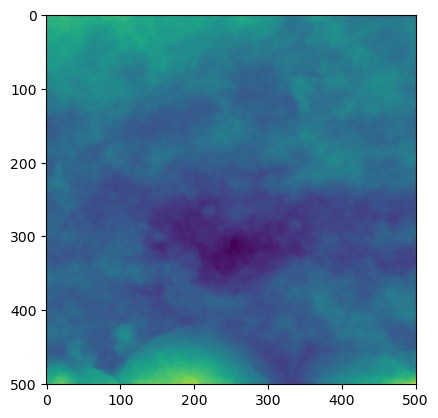

In [ ]:
plt.imshow(image)
plt.show()

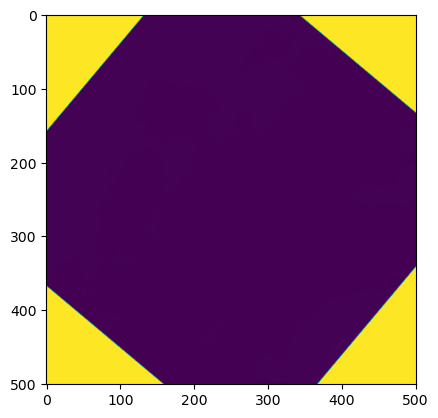

In [ ]:
#| hide
image_45 = imutils.rotate(image, angle = 50)
plt.imshow(image_45)
plt.show()

In [ ]:
image.shape

(501, 501)

It can be very useful to study how roughness parameters change with regards to their orientation. The following function helps produce a range of profiles rotating around the central point of the image or array

In [ ]:
#| export
def gen_rot_prof(array, #2D array of height values
                 deg       = 180, #Number of degrees to rotate through, i.e 180 gives full 360 rotation
                 increment = 1 # deg/increment = number of evenly spaced profiles to calculate.  
                ):
    
    ''' Generates an array of rotational profiles through to deg, in even increments of increment. 
    Uses OpenCV and Imutils to rotate the array around the center of the array/raster/image, extracts the middle row. 
    '''
    if deg % increment != 0:
        raise ValueError('Cannot sample evenly, deg % indent must = 0')
        
    profiles = np.zeros(shape = (deg//increment,array.shape[0]))
    index    = 0
    center   = array.shape[0]//2  #Center is returned as index to the right of center for even arrays
    
    for degree in range(0, deg, increment):
        rot_array          = imutils.rotate(array, angle = degree)
        profiles[index, :] = rot_array[center,:]
        index             += 1
    return profiles
            

Numpy likes the data in various forms for linear algebra, 
here is a helper to convert an (M,N) matrix into a (n,(X,Y,Z)) matrix. 


In [ ]:
#| export
def image2xyz(im):
    '''
    Converts 2D (m,n) image/array to xyz coordinates. Used for plane levelling
    '''
    
    m, n = im.shape
    Y, X = np.mgrid[:m,:n]
    xyz = np.column_stack((X.ravel(),Y.ravel(), im.ravel()))
    
    return xyz

In [ ]:
#| export 
def xyz2image(xyz, # (n,3) shape array 
             ):
    '''
    Helper to convert back from xyz (n,3) arrays to (M,N) image/matrices
    '''
    return xyz[:,2].reshape(np.max(xyz[:,1]) + 1,
                            np.max(xyz[:,0]) + 1)

              


In [ ]:
im_xyz = image2xyz(image)
im_xyz[:5]

array([[ 0.        ,  0.        , -0.89188266],
       [ 1.        ,  0.        , -0.8919338 ],
       [ 2.        ,  0.        , -0.89193225],
       [ 3.        ,  0.        , -0.89193505],
       [ 4.        ,  0.        , -0.89192402]])

## Levelling and Form Removal

In order to perform roughness calculations it is recommended to level the data and remove the underlying form.This produces a _S-F_ surface from the *primary *surface if we are using Standards terms. Because surfaces are always digitized and discretized in some way, the actual surface has to be modelled using some function. ISO software standards recommend using a Bicubic spline to remove the form. Because the function is an assumption, the user should choose their function based on their scientific knowledge of the surface and the goals of their research. Multiple functions can be tested and the results observed.  Here I provide a least-squares solution to the problem, computing the results in the same shape as the original image and subtract them. 

With the underlying form modeled, the funciton can be sampled from to generate a larger number of samples. 

In [ ]:
#| export
def remove_form(im, # 2D Numpy array or array like
               degree = 3, # Polynomial degree to remove
               return_form = False # Return the form/computed polynomial values instead of removing them from im
               ):
    '''
    Remove the form of the raster by fitting a polynomial of specified degree and subtracting it. 
    '''
    imagexyz = image2xyz(im)
    imagexy  = imagexyz[:,:2]
    imagez   = imagexyz[:,2]
    
    poly     = sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias = False) #No bias as it is introduced later
    features = poly.fit_transform(imagexy)
    
    poly_reg_model = sklearn.linear_model.LinearRegression() #Polynomial Regression Model
    poly_reg_model.fit(features, imagez)
    
    predictions    =  poly_reg_model.predict(features) #Get the fitted values
    form = predictions.reshape(int(np.max(imagexyz[:,1])) + 1, #Reshape the predictions into the original image dimensions
                               int(np.max(imagexyz[:,0])) + 1)
    if return_form:
        return form
    else:
        return im - form
    

In [ ]:
#| export 
def plane_level(im, #Numpy array or array like
                norm = True, #Normalize the data by subtracting the mean
                return_form = False
               ):
    '''
    Level an (m,n) array by computing the best fit plane and subtracting the results.
    Thin wrapper around `remove_form` with degree = 1. 
    '''
    if norm:
        im = im - np.mean(im, axis = None)
        
    return remove_form(im = im, degree = 1, return_form = return_form)

In [ ]:
w = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
u = np.array([[1,0,-1]]*3)
test_close(plane_level(w), np.zeros(w.shape))
test_close(plane_level(u), np.zeros(u.shape))
test_fail(plane_level, kwargs = dict(xyz=np.array([1])))
test_fail(plane_level, kwargs = dict(xyz=np.array([[1,1]])))

Text(0.5, 1.0, 'Levelling plane')

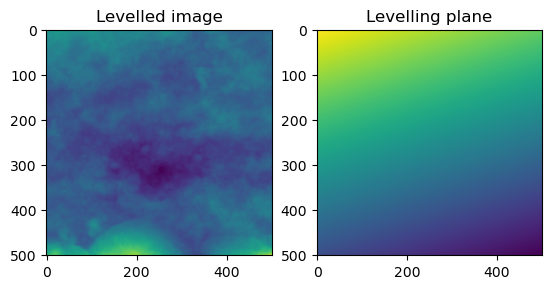

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(plane_level(image))
ax.set_title('Levelled image')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(plane_level(image, return_form = True))
ax.set_title('Levelling plane')

Text(0.5, 1.0, 'Polynomial')

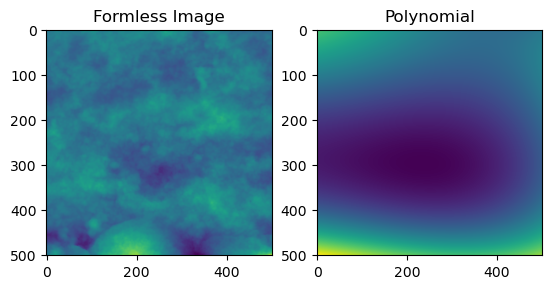

In [ ]:
image_f = remove_form(plane_level(image))
image_form = remove_form(plane_level(image), return_form = True)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image_f)
ax.set_title('Formless Image')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(image_form)
ax.set_title('Polynomial')

## Noise and smoothing

Similarly, it is recommended to remove noise and attenuate high frequency features. We achieve this through the use of a gaussian filter. 

In [ ]:
#| export
def smooth_image(array,         #Numpy array or array like
                 sigma = None,  #Standard deviation for gaussian kernel Useful for determining the wavelength of the low pass filter.
                 alpha = None,  #Used in gaussian weighting function, defaults to np.sqrt(np.log(2)/np.pi) 
                 cutoff = None, #Cutoff wavelength, defaults to 1
                 axis  = None,  # Axis along which to apply filter 
                 **kwargs #Keyword arguments for modification of the gaussian_filter function
                ):
    '''
    Removes high frequency/wavelength features ('noise') by applying a gaussian filter on the image. 
    Thin wrapper of scipy.ndimage.gaussian_filter.
    
    If all sigma,alpha,cutoff =  None, sigma defaults to (np.sqrt(np.log(2)/np.pi)) * cutoff
    
    If sigma is not none, sigma takes priority over any alpha or cutoff provided. 
    
    Refer to ISO 11562:1997 for reasoning behind alpha and cutoff.
    '''
    if sigma is None:
        if alpha is None: 
            alpha = np.sqrt(np.log(2)/np.pi)
        if cutoff is None:
            cutoff = 1
        sigma = alpha * cutoff 
    
    return ndimage.gaussian_filter(input = array, sigma = sigma, axes = axis, **kwargs)

Text(0.5, 1.0, 'Sigma = 10')

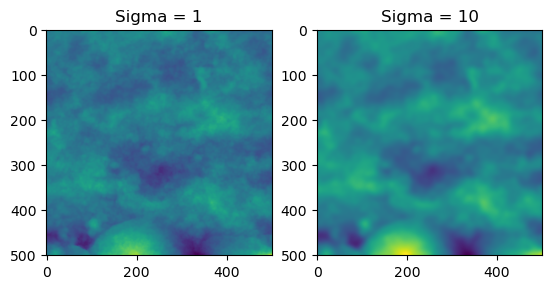

In [ ]:
image_f_s = smooth_image(image_f,cutoff=1)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image_f_s)
ax.set_title('Sigma = 1')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(smooth_image(image_f,cutoff=10))
ax.set_title('Sigma = 10')

## Sections
 
 It can be useful to study subsections of surfaces. The following helpers assist with this process. Otherwise, normal manipulation of numpy arrays is always possible.

In [ ]:
#| export
def gen_sections(image, #2D array (or arraylike) of height values
                how = 'square', #How to subdivide the array, options are: 'square', 'row', 'column'
                number = 100, #Number of sections to produce
                
                ):
    '''
    Generates sections of the array/image, either in square, horizontal, or vertical sections.
    Useful for studying the change of parameters over the surface.
    Mostly wraps around np.hsplit and np.vsplit.
    Note, if 'number' does not divide into the array evenly, the bottom/side remains will not be
    included. 
    '''
    if how not in ['square','row','column']:
        raise ValueError('Invalid how, expected one of:')
   
    if how == 'square':
        im_height, im_width = image.shape
        length   = number**0.5
        roww     = int(im_height//length)
        colw     = int(im_width//length) 

        image = image[:(im_height - (im_height % roww)), :(im_width - (im_width % colw))] #Remove extra rows/columns
        
        #https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
        #reshape_formula = a_10000.reshape(int(im_height/tile),tile,int(im_width/tile),tile,channels)
        image_reshaped = image.reshape(int(im_height/roww),roww,int(im_width/colw),colw)
        
        tiled_image = image_reshaped.swapaxes(1,2)
        
        sectioned_image = tiled_image.reshape(-1,roww,colw)
        return sectioned_image
    
    if how == 'row':
        return np.vsplit(image, number)
    
    if how == 'column':
        return np.hsplit(image, number)

In [ ]:
a_10000 = np.arange(100*100).reshape(100,100)
test_eq(gen_sections(a_10000)[0],a_10000[:10,:10])

a_523 = np.arange(523*523).reshape(523,523)
a_520 = np.arange(520*520).reshape(520,520)
test_eq(gen_sections(a_523).shape,gen_sections(a_520).shape)

In [ ]:
test_sections = np.load('example_sections.npy')
test_sections.shape

(100, 50, 50)

In [ ]:
image_sections =  gen_sections(image)

Now, because we've applied all of our preprocessing steps to the original image. We can export it for use later.
We should also save our profiles and sections. The sections should be in .npy format because they are 3D.

In [ ]:
np.savetxt('example.txt', image_f_s)
np.savetxt('example_profiles.txt', gen_rot_prof(image_f_s))
np.save('example_sections.npy', image_sections)

And we can load them back in just to check.

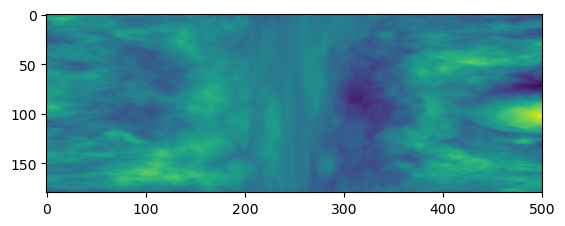

In [ ]:
profiles = np.loadtxt('example_profiles.txt')
plt.imshow(profiles)
plt.show()

# Utilities
> Various useful functions which are used elsewhere

In [ ]:
#| export
def compute_parameters(array, #Input array to be calculate parameters on
                       parameter_list:list,  #List of parameters to calculate as strings
                       valid_module  = None, #module to generate functions from, used to check user input, see rough.cli:rough
                       to_df:bool    = False,#Return the parameters as a pandas dataframe, with columns set as the parameter names
                       **kwargs              #Keyword arguments to modify behavior of parameter calls, usually to define sections = True or the axis. 
                      ):
    '''
    Computes a set of parameters for a given array, provide a list of parameters (as strings of their respective functions e.g. ['Ra','Rms']) and a module
    to verify against (might require some module aliasing, see CLI notebook for example use). Returns a list of results or a dataframe.
    '''
    
    results = []
    
    #The following generates a {'func':func} dict from given list of parameters if the parameter is available in the module
    valid_dict = {k: v for k, v in vars(valid_module).items() if callable(v) and k in valid_module.__all__}
    for parameter in parameter_list:
        result = valid_dict[parameter](array, **kwargs)
        results.append(result)
        
    if to_df:
        results_array = np.array(results)
        if len(results_array.shape) == 1: results_array = np.expand_dims(results_array, axis=1) #Fix for when only 1 section is being calculated
        return pd.DataFrame(data = results_array.T, columns = parameter_list)
    else:
        return results

In [ ]:
#| export
def distance_matrix(shape: tuple, #Shape of array, used to calculate center if not given
                    center: (int,int) = None, #Central point from which to calculate distances, if None, defaults to x//2, y//2
                    sections = False, #If True, takes the first element of shape as the number of stack in image
                   ):
    '''
    Returns a (m,n) matrix containing distance values from center coordinates.
    
    if Sections = True. Returns (x,m,n) where x is the number of input sections. 
    
    '''
    if sections:
        n_stack = shape[0]
        shape   = shape[1:]
    if center is None:
        center = (shape[0]//2,shape[1]//2)
        
    y_arr, x_arr = np.mgrid[0:shape[0],0:shape[1]]
    #Pythagoras
    return np.sqrt(((y_arr - center[0])**2) + ((x_arr - center[1]) ** 2))
        
    

In [ ]:
a25 = np.arange(25).reshape(5,5)

In [ ]:
a25.shape

(5, 5)

In [ ]:
a25t = np.tile(a25,(5,5,5))

In [ ]:
test_eq(a25t[0],a25t[4])

In [ ]:
test_shape = (101,101)
#eps = 1e-05
test_eq(distance_matrix(test_shape), np.rot90(distance_matrix(test_shape)))
test_eq(distance_matrix(test_shape), np.flipud(distance_matrix(test_shape)))
test_eq(distance_matrix(test_shape), np.fliplr(distance_matrix(test_shape)))

test_ne(distance_matrix(test_shape), np.zeros(test_shape))
test_ne(distance_matrix(test_shape), np.ones(test_shape))

In [ ]:
#| export
def normalize(im, #Array or stack of array to normalize
              axis = 1, #Axis along which to normalize
              how = 'center', #normalization method: 'center', 'standardize', 'minmax'
              feature_range = None, #Tuple containing the feature range for minmax
             ):
    '''
    Normalize the input array along given axis. Typically used to 'center' rows/columns/areas in order to calculate parameters.
    how can be:
    - 'center': Subtract the mean from the array along the axis,
    - 'l1'
    - 'l2'
    - 'standardize' : Subtract the mean and divide by the standard deviation along given axis
    - 'minmax' : 'standardize' within 'feature_range'. See use in `Sal`
    
    Mostly a reimplementation of scalers from sklearn with explicit formulation. 
    '''
    if how == 'center':
        return im - np.mean(im,axis=axis,keepdims= True)
    elif how == 'standardize':
        return ((im - np.mean(im,axis=axis,keepdims=True)) / np.std(im,axis=axis,keepdims= True))
    elif how == 'minmax':
        if feature_range is None:
            feature_range = (-1,1)
            
        im_std = (im - np.amin(im,axis=axis,keepdims=True)) / np.ptp(im,axis=axis,keepdims=True)
        min_r,max_r = feature_range 
        return im_std * (max_r - min_r) + min_r
    elif how == 'none':
        return im
    

In [ ]:
#For testing normalize
from sklearn.preprocessing import MinMaxScaler

In [ ]:
a_400 =np.arange(-200,200).reshape(-1,1)
a_rand = np.random.randint(-1000,1000,1000).reshape(-1,1)
scaler = MinMaxScaler((-1,1))

test_eq((a_400 - np.mean(a_400,axis = 0,keepdims = True)), normalize(a_400, axis = 0, how = 'center'))
test_eq((a_rand - np.mean(a_rand,axis = 0, keepdims = True)), normalize(a_rand,axis = 0, how = 'center'))

test_close(scaler.fit_transform(a_400),  normalize(a_400,axis = 0, how = 'minmax'), eps = 1e-10)
test_close(scaler.fit_transform(a_rand), normalize(a_rand,axis = 0, how = 'minmax'), eps = 1e-10)

In [ ]:
image_f_s.shape

(501, 501)

In [ ]:
from scipy.signal import correlate

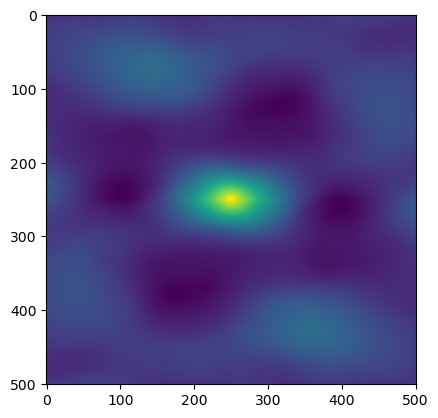

In [ ]:
cor_result = correlate(image_f_s, image_f_s,mode='same')
plt.imshow(cor_result)
plt.show()

In [ ]:
correlate(np.ones((3,3)), np.ones((3,3)), mode = 'same')

array([[4., 6., 4.],
       [6., 9., 6.],
       [4., 6., 4.]])

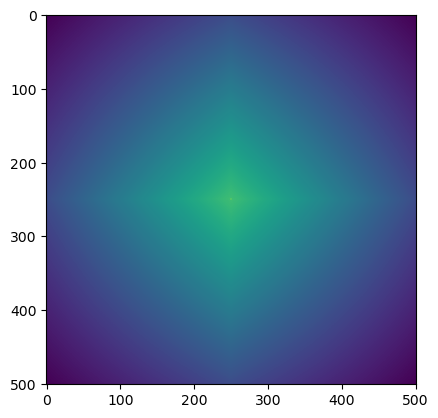

In [ ]:
rand_arr = np.random.rand(501,501)
rand_cor = correlate(rand_arr,rand_arr,mode='same')
plt.imshow(rand_cor)
plt.show()

In [ ]:
(np.amax(rand_cor),np.amin(rand_cor),np.ptp(rand_cor))

(83658.4682965728, 15694.409983652164, 67964.05831292064)

In [ ]:
rand_ncor = normalize(rand_cor,axis = None, how= 'minmax')

In [ ]:
(np.amax(rand_ncor),np.amin(rand_ncor),np.ptp(rand_ncor))

(1.0, -1.0, 2.0)

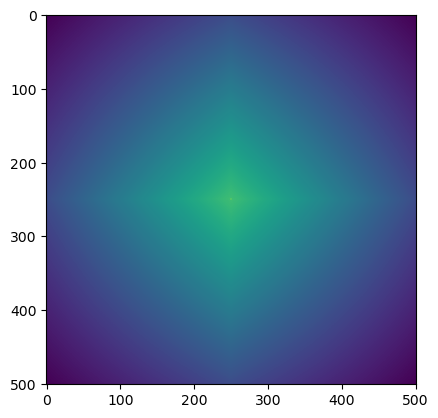

In [ ]:
plt.imshow(rand_ncor)
plt.show()

In [ ]:
rand_dist = distance_matrix(rand_ncor.shape)

In [ ]:
rand_where = np.where(rand_ncor <= 0.2, rand_dist, np.NaN)
np.nanmin(rand_where)

36.76955262170047

In [ ]:
x = np.linspace(0, 20)
y = np.sin(x)
sin_wave = np.broadcast_to(y,(50,50))

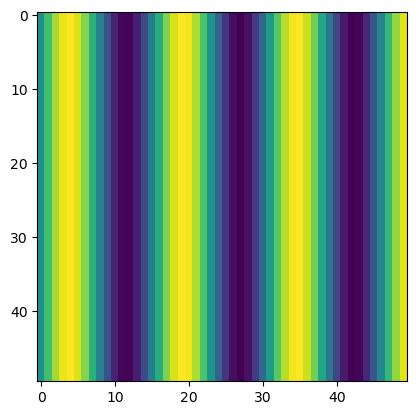

In [ ]:
plt.imshow(sin_wave)
plt.show()

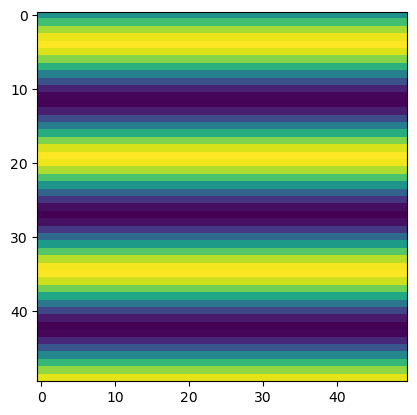

In [ ]:
plt.imshow(sin_wave.T)
plt.show()

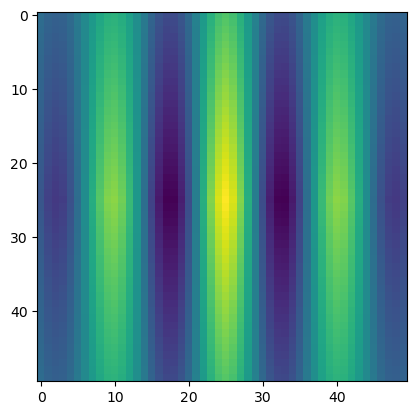

In [ ]:
sin_cor = correlate(sin_wave,sin_wave,mode='same')
plt.imshow(sin_cor)
plt.show()

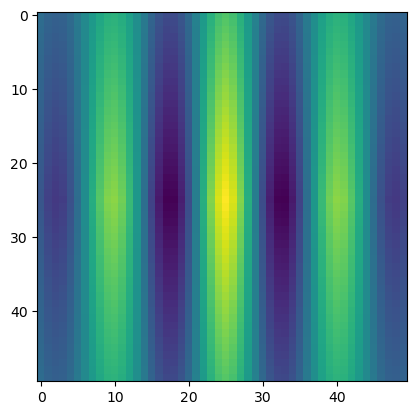

In [ ]:
ncor_sin = normalize(sin_cor, axis = None, how = 'minmax')
plt.imshow(ncor_sin)
plt.show()

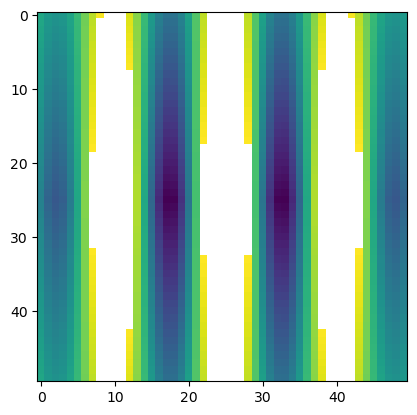

In [ ]:
ncor_sin_2 = np.where(ncor_sin <=0.2, ncor_sin, np.NaN)
plt.imshow(ncor_sin_2)
plt.show()

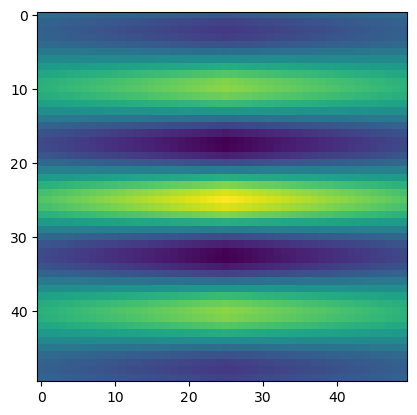

In [ ]:
sint_cor = correlate(sin_wave.T,sin_wave.T,mode='same')
plt.imshow(sint_cor)
plt.show()

In [ ]:
sin_cor[-1,-1]

-302.59161125378563

In [ ]:
(np.ptp(cor_result),np.max(cor_result),np.min(cor_result))

(0.12309696498814524, 0.10140944660491391, -0.021687518383231318)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()